In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import scipy as sp
import matplotlib.pyplot as plt
import re
from os import listdir
from os.path import isfile, join
from scipy import stats

from sklearn import preprocessing

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.ensemble import VotingClassifier

# Evaluation Procedures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import precision_recall_curve 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

In [2]:
rare_AD = pd.read_csv('../Data/data_AR_rare_1319_new.csv')

In [3]:
pheno = pd.read_csv('../Data/phenotypes_1319.csv',sep=';')

In [4]:
rare_AD.drop(columns=['ARSD', 'ATP6AP1', 'FRMPD4', 'SHROOM4', 'SOX21', 'SLC24A5','NPIPB15', 'FAM9A', 'SUPT20HL1', 'VCX3A', 'VCX3B'], inplace=True, axis=1)
rare_AD_1 = rare_AD.reset_index()
rare_AD_1.drop(columns=['index','Unnamed: 0'], inplace=True)
value_counts = rare_AD_1.apply(pd.Series.value_counts)
value_counts = value_counts.transpose()
value_counts.columns = value_counts.columns.astype(str)
value_counts = value_counts.reset_index()
value_counts.rename(columns={'index':'mutation',1:'1',0:'0'}, inplace=True)
value_counts['percentage of 1'] = value_counts.apply(lambda row : row['1']/(len(rare_AD_1)), axis=1)

In [5]:
rare_AD.drop(columns=value_counts[value_counts['percentage of 1'] > 0.0983].mutation, inplace=True, axis=1)

In [6]:
value_counts[value_counts['0'] >= len(rare_AD_1)]

,mutation,0,1,percentage of 1
2,AADACL4,1318.0,NaN,NaN
5,ABCD3,1318.0,NaN,NaN
6,ABL2,1318.0,NaN,NaN
8,ACAP3,1318.0,NaN,NaN
9,ACBD3,1318.0,NaN,NaN
...,...,...,...,...
18014,VMA21,1318.0,NaN,NaN
18025,XG,1318.0,NaN,NaN
18032,ZBED1,1318.0,NaN,NaN
18040,ZDHHC9,1318.0,NaN,NaN


In [7]:
value_counts[value_counts['percentage of 1'] >= 0.0983]

,mutation,0,1,percentage of 1
1,AADACL3,946.0,372.0,0.282246
73,ANKRD35,164.0,1154.0,0.875569
125,AVPR1B,1119.0,199.0,0.150986
250,CD164L2,2.0,1316.0,0.998483
278,CDK11A,1080.0,238.0,0.180577
...,...,...,...,...
17920,SPANXN3,193.0,1125.0,0.853566
17926,SRPX,1164.0,154.0,0.116844
17998,UBE2NL,1030.0,288.0,0.218513
18011,VCX,1185.0,133.0,0.100910


Mantengo solo pazienti con un grading

In [8]:
pheno = pheno[pheno['grading_1319_adj_a_s'].notna()]

Scarto pazienti senza età

In [9]:
pheno = pheno[pheno['Age'].notna()]

Cambio l'indice dei pazienti

In [10]:
pheno.rename(columns={"UsedSampleCode":"key"}, inplace=True)
pheno.set_index('key',inplace=True)

In [11]:
len(pheno)

1312

Scarto pazienti da escludere

In [12]:
rare_AD.rename(columns={"Unnamed: 0": "key"}, inplace=True)
rare_AD.set_index('key',inplace=True)

rare_AD = rare_AD[rare_AD.index != 'COV2925-1241_hg38']
rare_AD = rare_AD[rare_AD.index != 'COV2928-1242_hg38']
rare_AD = rare_AD[rare_AD.index != 'COV3204-1334_hg38']
rare_AD = rare_AD[rare_AD.index != 'COV3196-1326_hg38']
rare_AD = rare_AD[rare_AD.index != 'COV2735-1159_hg38']
rare_AD = rare_AD[rare_AD.index != 'COV3211-1341_hg38']
rare_AD = rare_AD[rare_AD.index != 'COV2233-939_hg38']

rare_AD.index = rare_AD.index.str.replace('_hg38','')

In [13]:
grading = pheno[['Gender (M=0, F=1)','grading_1319_adj_a_s']]

df = grading.join(rare_AD, on='key')
df.rename(columns={'grading_1319_adj_a_s':'grading'}, inplace=True)

df = df[df['grading']!='none']
df.dropna(inplace=True)
df

,"Gender (M=0, F=1)",grading,A3GALT2,AADACL4,ABCA4,ABCB10,ABCD3,ABL2,ACADM,ACAP3,...,NLGN4Y,PCDH11Y,PRORY,RPS4Y1,RPS4Y2,TBL1Y,TMSB4Y,USP9Y,UTY,ZFY
key,,,,,,,,,,,,,,,,,,,,,
AR-COV-1,1.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AR-COV-10,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AR-COV-11,1.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AR-COV-13,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AR-COV-14,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
USCASI0004,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
USCASI0005,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
VE10,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Mantengo solo i maschi

In [14]:
df['Gender (M=0, F=1)'].value_counts()

0.0    491
1.0    327
Name: Gender (M=0, F=1), dtype: int64

In [15]:
df = df[df['Gender (M=0, F=1)']==1].iloc[:,1:]

In [16]:
df = df.apply(pd.to_numeric, errors='coerce')
df = df.dropna()
df.reset_index(inplace=True)

In [17]:
df.drop(columns='key',inplace=True)

In [18]:
df

,grading,A3GALT2,AADACL4,ABCA4,ABCB10,ABCD3,ABL2,ACADM,ACAP3,ACBD3,...,NLGN4Y,PCDH11Y,PRORY,RPS4Y1,RPS4Y2,TBL1Y,TMSB4Y,USP9Y,UTY,ZFY
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
323,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
324,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
325,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Rimuovo i geni non informativi

In [19]:
df1 = df[df.columns].apply(lambda x: x.astype('int64'))

In [20]:
value_counts = df1.apply(pd.Series.value_counts)
value_counts = value_counts.transpose()
value_counts.columns = value_counts.columns.astype(str)
value_counts = value_counts.reset_index()
value_counts.rename(columns={'index':'mutation',1:'1',0:'0'}, inplace=True)
value_counts['percentage of 1'] = value_counts.apply(lambda row : row['1']/(len(df)), axis=1)

In [21]:
df.drop(columns=value_counts[value_counts['0'] >= len(df)].mutation, inplace=True, axis=1)
df.drop(columns=value_counts[value_counts['1'] >= len(df)].mutation, inplace=True, axis=1)

Rimuovo i geni del cromosoma X

In [22]:
chr_X = pd.read_csv('../Data/Male/genes_chrX.csv')
genes_X = np.intersect1d(chr_X['genes_x'].tolist(), df.columns.tolist())

In [23]:
df.drop(columns=genes_X, inplace=True)

# Optimizing Lasso Classification 

Rimuovo i geni del cromosoma X

In [24]:
chr_X = pd.read_csv('../Data/Male/genes_chrX.csv')
genes_X = np.intersect1d(chr_X['genes_x'].tolist(), df.columns.tolist())

In [25]:
df.drop(columns=genes_X,inplace=True)

In [26]:
target_variable = 'grading'
input_variables = df.columns[df.columns!=target_variable]

X = df[input_variables]
y = df[target_variable]
X_nic = pd.read_csv('../Data/Male/ar_male_antonio.csv', sep=';')
y_nic = pd.read_csv('../Data/Male/ar_male_antonio_y.csv', sep=';')['0']

In [27]:
X_nic

,Unnamed: 0,A3GALT2_rare_AR,ABCA4_rare_AR,ABCB10_rare_AR,ACADM_rare_AR,ACKR1_rare_AR,ACOT11_rare_AR,ACP6_rare_AR,ACTN2_rare_AR,ADAMTSL4_rare_AR,...,XAGE2_rare_AR,AMELY_rare_AR,DDX3Y_rare_AR,KDM5D_rare_AR,NLGN4Y_rare_AR,PRORY_rare_AR,TBL1Y_rare_AR,USP9Y_rare_AR,UTY_rare_AR,ZFY_rare_AR
0,AR-COV-10_hg38,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AR-COV-13_hg38,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AR-COV-14_hg38,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AR-COV-18_hg38,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AR-COV-19_hg38,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487,USCASI0002_hg38,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
488,USCASI0004_hg38,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
489,USCASI0005_hg38,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
490,VE10_hg38,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
X

,A3GALT2,ABCA4,ACKR1,ADAM30,ADAMTSL4,ADGRB2,ADGRL2,ADPRHL2,AGMAT,AGRN,...,TXNRD2,VPREB3,XPNPEP3,ZBED4,ZNF74,AKAP17A,ASMTL,PLCXD1,SHOX,PCDH11Y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
324,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
325,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [29]:
X_nic.drop(columns='Unnamed: 0', inplace= True)

In [30]:
X.columns += '_rare_AR'

In [31]:
np.setdiff1d(X.columns, X_nic.columns).shape[0]

1198

In [32]:
print("Class %2d  %.1f%%\nClass %2d  %.1f%%\n"%((y.value_counts()/y.shape[0]).index[0],100*(y.value_counts()/y.shape[0]).values[0],(y.value_counts()/y.shape[0]).index[1],100*(y.value_counts()/y.shape[0]).values[1]))

Class  1  53.5%
Class  0  46.5%



In [33]:
np.random.seed(1234)

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, train_size= 0.9, random_state=1234, shuffle=True)

crossvalidation = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)

In [34]:
c = np.logspace(np.log10(1e-2), np.log10(1e3), 51)

In [35]:
lasso = LogisticRegression(random_state=1234, solver="liblinear", penalty='l1',verbose=1)
parameters = {'C':c}
lasso_gs = GridSearchCV(lasso, parameters, n_jobs=-1, cv=crossvalidation, scoring='roc_auc')
lasso_gs.fit(X,y)

[LibLinear]

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=1234, shuffle=True),
             estimator=LogisticRegression(penalty='l1', random_state=1234,
                                          solver='liblinear', verbose=1),
             n_jobs=-1,
             param_grid={'C': array([1.00000000e-02, 1.25892541e-02, 1.58489319e-02, 1.99526231e-02,
       2.51188643e-02, 3.16227766e-02, 3.98107171e-02, 5.01187234e-02,
       6.30957344e-02, 7.94328235e-02, 1...
       6.30957344e+00, 7.94328235e+00, 1.00000000e+01, 1.25892541e+01,
       1.58489319e+01, 1.99526231e+01, 2.51188643e+01, 3.16227766e+01,
       3.98107171e+01, 5.01187234e+01, 6.30957344e+01, 7.94328235e+01,
       1.00000000e+02, 1.25892541e+02, 1.58489319e+02, 1.99526231e+02,
       2.51188643e+02, 3.16227766e+02, 3.98107171e+02, 5.01187234e+02,
       6.30957344e+02, 7.94328235e+02, 1.00000000e+03])},
             scoring='roc_auc')

In [36]:
s = {'score':lasso_gs.cv_results_['mean_test_score'],'std':lasso_gs.cv_results_['std_test_score'],'c':1/c}
scores = pd.DataFrame(data=s)

In [37]:
sns.set_theme()
plt.figure(figsize=(15,7))
ax = sns.lineplot(data=scores, x='c', y='score', ci=scores.std, markers=True, marker='o')
ax.fill_between(1/parameters['C'], y1=lasso_gs.cv_results_['mean_test_score'] - lasso_gs.cv_results_['std_test_score'], 
                y2=lasso_gs.cv_results_['mean_test_score'] + lasso_gs.cv_results_['std_test_score'], alpha=.2)
ax.set_xscale('log')
ax.set_ylabel('ROC AUC')
ax.set_xlabel('REGULARIZATION FACTOR')
ax.set_title('Lasso LogisticRegression GridSearch')
plt.plot(1/parameters['C'][14],lasso_gs.cv_results_['mean_test_score'][14], 'ok', markersize=5, color='red')
plt.savefig('./Plots/GS_AR_rare_female.png', dpi=150)
#ax.set_ylim([0.475,0.7])

AttributeError: module 'seaborn' has no attribute 'set_theme'

In [38]:
lasso_gs.best_estimator_

LogisticRegression(C=0.19952623149688797, penalty='l1', random_state=1234,
                   solver='liblinear', verbose=1)

In [39]:
c_nicola = 0.125892541

In [40]:
c[14]

0.25118864315095807

In [41]:
method_name = 'Lasso'

#lasso = lasso_gs.best_estimator_
lasso = LogisticRegression(C=c[14], penalty='l1', random_state=1234, solver='liblinear', verbose=1)

xval_score = cross_val_score(lasso,X,y,cv=crossvalidation)

# compute the basic statistics
accuracy_mean = np.average(xval_score)
accuracy_std = np.std(xval_score)

lasso.fit(X,y)

importances = lasso.coef_

prec = np.average(cross_val_score(lasso,X,y,cv=crossvalidation, scoring='precision'))
    
rec = np.average(cross_val_score(lasso,X,y,cv=crossvalidation, scoring='recall'))
    
f1_metric = np.average(cross_val_score(lasso,X,y,cv=crossvalidation, scoring='f1'))
    
auc_metric = np.average(cross_val_score(lasso,X,y,cv=crossvalidation, scoring='roc_auc'))


print('\n')    
print("%40s"%method_name)
print("========================================")
print("\t  Accuracy (CV) %.3f %.3f"%(np.average(xval_score),np.std(xval_score)))
print("\t      Precision %.3f"%prec)
print("\t      Recall    %.3f"%rec)
print("\t      F1        %.3f"%f1_metric)
print("\t      AUC        %.3f"%auc_metric)
print("\n")

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

                                   Lasso
	  Accuracy (CV) 0.520 0.026
	      Precision 0.584
	      Recall    0.578
	      F1        0.519
	      AUC        0.567




In [42]:
importances = lasso.coef_.flatten()
importances.shape[0]

3988

In [43]:
indices = np.argsort(np.absolute(importances))[::-1]#[0:100]
indices = indices[np.absolute(importances[indices])>0.000001]

In [44]:
selected_features = importances[indices]

In [45]:
len(selected_features)

8

In [46]:
df = pd.DataFrame(data={'gene':X.columns[indices], 'importance':importances[indices]})
df.to_csv('../2022_results/importances_rare_AR_F.csv')
df

,gene,importance
0,CAMKK2_rare_AR,0.631437
1,WDR27_rare_AR,0.491986
2,PKHD1L1_rare_AR,0.276071
3,NKX2-3_rare_AR,-0.268049
4,TNFAIP2_rare_AR,-0.154489
5,OR51B5_rare_AR,-0.113185
6,TACR2_rare_AR,0.058392
7,HRCT1_rare_AR,0.043092


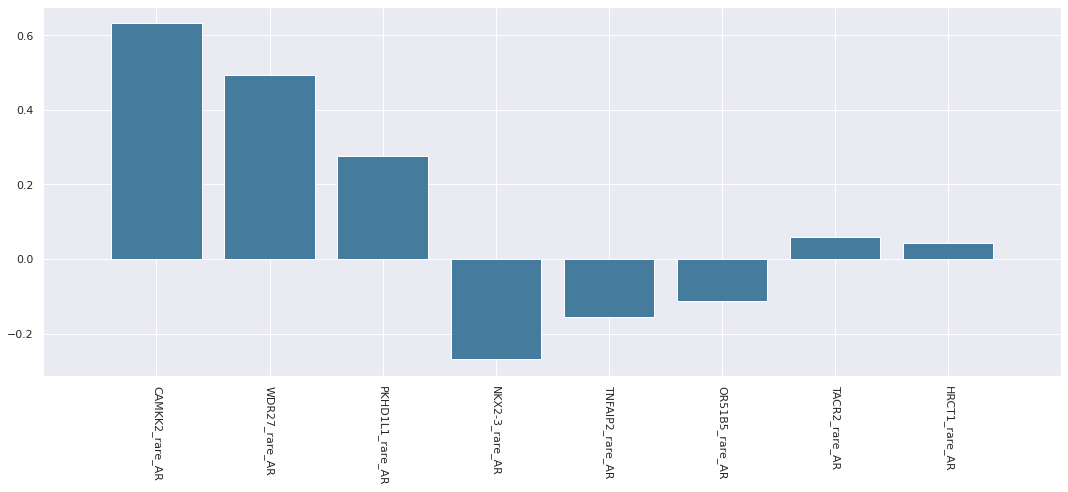

In [49]:
sns.set_theme()
n_features = len(selected_features)

fig, ax = plt.subplots(figsize=(15,7))

#plt.title("Lasso Feature importances male rare AD")

ax.bar(range(n_features), importances[indices],
        color="#457b9d", yerr=None, align="center")

plt.xticks(range(n_features), X.columns[indices],rotation='-90')
#ax.get_xticklabels()[1].set_fontweight("bold")
#ax.get_xticklabels()[4].set_fontweight("bold")
#ax.get_xticklabels()[16].set_fontweight("bold")

plt.xlim([-1, len(selected_features)])#X.shape[1]])
plt.tight_layout()
#plt.savefig('./Plots/Feature_importances_adjbyage.png',dpi=150)
plt.savefig('./Plots/Selected_AR_rare_female.png', dpi=150)
plt.show()

In [40]:
yp_cv = cross_val_predict(lasso, X, y, cv=crossvalidation)
tn, fp, fn, tp = confusion_matrix(y, yp_cv).ravel()

#tn, fp, fn, tp = confusion_matrix(y_test, yp).ravel()

conf = [[tn,fn],[fp,tp]]

confusion = np.array(conf)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

Text(0.5, 1.0, 'Lasso Confusion Matrix')

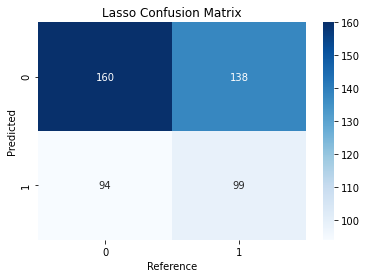

In [41]:
ax = sns.heatmap(confusion, annot=True, cmap='Blues',fmt='g')
ax.set_ylabel('Predicted')
ax.set_xlabel('Reference')
ax.set_title('Lasso Confusion Matrix')
#ax.set_xticklabels(['Absent','Present'])
#ax.set_yticklabels(['Absent','Present'])
#plt.savefig('./Plots/Lasso Confusion matrix adj by age.png', dpi=150)